In [1]:
import math
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import matplotlib
import time
import scanpy as sc
import sklearn
import networkx as nx
import ot
import paste as pst
#%load_ext autoreload
#%autoreload 2
# style.use('seaborn-dark')
style.use('seaborn-white')

In [2]:
sample_list = ["151507", "151508", "151509","151510", "151669", "151670","151671", "151672", "151673","151674", "151675", "151676"]
adatas = {sample:sc.read_h5ad('../data/DLPFC/{0}_preprocessed.h5'.format(sample)) for sample in sample_list}
sample_groups = [["151507", "151508", "151509","151510"],[ "151669", "151670","151671", "151672"],[ "151673","151674", "151675", "151676"]]
layer_groups = [[adatas[sample_groups[j][i]] for i in range(len(sample_groups[j]))] for j in range(len(sample_groups))]
layer_to_color_map = {'Layer{0}'.format(i+1):sns.color_palette()[i] for i in range(6)}
layer_to_color_map['WM'] = sns.color_palette()[6]

In [9]:
temp_df = pd.DataFrame(columns=['PCs','Layer1','Layer2', 'Layer3','Layer4', 'Layer5', 'Layer6', 'WM'])
pcs = [2,10,100,1000,10000]
for pc in pcs:
    pca = sklearn.decomposition.TruncatedSVD(n_components=pc)
    X_transformed = pca.fit_transform(adatas['151674'].X)
    X_tilde = X_transformed.dot(pca.components_)
    X_tilde[X_tilde<0] = 0
    temp_adata = adatas['151674'].copy()
    temp_adata.X = X_tilde.copy() #(adatas['151674'].X.toarray()!=0)*X_tilde #X_tilde.copy() #np.dot(W_best,H_best)
    sc.pp.calculate_qc_metrics(temp_adata, inplace=True)
    sc.pp.normalize_total(temp_adata, inplace=True)
    sc.pp.log1p(temp_adata)
    sc.tl.rank_genes_groups(temp_adata, "layer_guess_reordered", method="wilcoxon")
    temp_df.loc[len(temp_df)] = [pc] + [np.sum(temp_adata.uns['rank_genes_groups']['pvals_adj'][l]<=1e-2) for l in ['Layer1','Layer2', 'Layer3','Layer4', 'Layer5', 'Layer6', 'WM']]
temp_df

,PCs,Layer1,Layer2,Layer3,Layer4,Layer5,Layer6,WM
0,2,12,12381,12381,12381,10,12381,12381
1,10,9670,9523,11250,8819,10021,9917,11942
2,100,8107,6967,9411,6069,8339,7131,10733
3,1000,3007,1507,5199,909,2812,1462,7271
4,10000,11866,686,6641,424,2780,2090,3367


Text(0.5, 1.0, '# Significant differntially expressed genes following PCA')

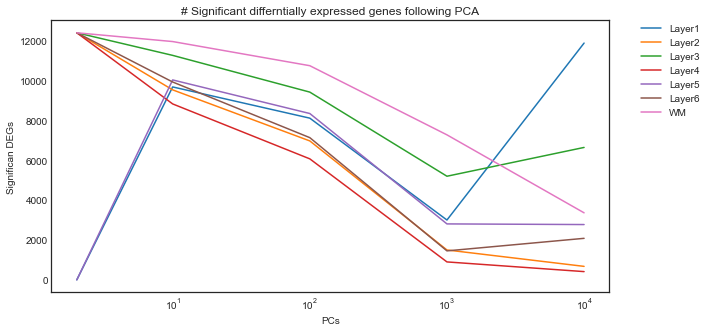

In [10]:
plt.figure(figsize=(10,5))
g = sns.lineplot(data=pd.DataFrame([[temp_df.iloc[i,0],temp_df.columns[1+l],temp_df.iloc[i,1+l]] for i in range(len(temp_df)) for l in range(7)],columns=['PCs','Layer','Significan DEGs']),
             x='PCs',y='Significan DEGs',hue='Layer')
g.set(xscale='log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_title('# Significant differntially expressed genes following PCA')

In [4]:
center_layer = sc.read_h5ad("../data/DLPFC/saved_results/center2_a0.1_KL_seed2.h5ad")
center_adata = adatas['151674'].copy()
center_adata = center_adata[:,center_layer.var_names]
center_adata.X = center_layer.X

/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [5]:
adata_copy = center_adata.copy()
sc.pp.normalize_total(adata_copy, inplace=True)
sc.pp.log1p(adata_copy)
sc.tl.rank_genes_groups(adata_copy, "layer_guess_reordered", method="wilcoxon")`

In [6]:
for l in ['Layer1','Layer2', 'Layer3','Layer4', 'Layer5', 'Layer6', 'WM']:
    v = adata_copy.uns['rank_genes_groups']['pvals_adj'][l]
#     print(l,np.sum(v<=1e-2),np.sum(v<=1e-2)/len(v))
    print(' & ', np.sum(v<=1e-2),end='')

 &  9330 &  8902 &  9666 &  8678 &  9322 &  9110 &  10202

In [7]:
def rank_genes_groups_for_model(my_adata,groups,method="wilcoxon",remove_mt=True,plot=False):
    print('\t',groups)
    my_adata.obs['MyGroups'] = pd.Series(my_adata.obs['layer_guess_reordered'].isin(groups).map(str),index=my_adata.obs.index,dtype='category')
    if remove_mt: my_adata = my_adata[:,[name for name in my_adata.var_names if not name.startswith('MT-')]]
    sc.tl.rank_genes_groups(my_adata, "MyGroups",groups=['True'], method=method)
    if plot: sc.pl.rank_genes_groups(my_adata, n_genes=25, sharey=False)
    return my_adata.uns['rank_genes_groups']
def get_gene_rank_res(res,gene,model=''):
    i=np.where(np.array(res['names']['True']==gene))[0][0]
    return pd.DataFrame([[gene,model,res['pvals']['True'][i],res['pvals_adj']['True'][i],res['scores']['True'][i],res['logfoldchanges']['True'][i],i]],
                        columns=['gene_name','models','pval','pval_adj','score','logfoldchanges','rank'])


def analyze_gold_standard_markers(my_adata,file_name='../data/DLPFC/spatialLIBD_table_S5.csv',method='wilcoxon'):
    df = pd.read_csv(file_name,index_col=0,sep=',')
    models = [tuple(sorted(s.split('+'))) for s in pd.unique(df['models'])]
    rank_genes_groups = {mod:rank_genes_groups_for_model(my_adata,mod,method) for mod in models}
    res_df = pd.DataFrame([],columns=['gene_name','models','pval','pval_adj','score','logfoldchanges','rank'])
#     for i in df.index:
#         gene,model_name = tuple(df.loc[i,['gene_name','models']])
    for i in range(len(df)):
        gene,model_name = df.iloc[i].name.upper(),df.iloc[i]['models']
        model = tuple(sorted(model_name.split('+')))
        if model in rank_genes_groups and gene in my_adata.var.index:
            gene_df = get_gene_rank_res(rank_genes_groups[model],gene,model_name)
            res_df = res_df.append(gene_df,ignore_index=True)
    return res_df.sort_values(['pval', 'pval_adj','score','logfoldchanges'],ascending=[True,True,False,False])

In [8]:
def get_gene_ranks_from_all_test(my_adata,genes,models):
    temp_df = pd.DataFrame([],columns=['gene_name','models','rank','pval','pval_adj','score','logfoldchanges'])
    for j in range(len(genes)):
        gene, model = genes[j],models[j]
        i=np.where(np.array(my_adata.uns['rank_genes_groups']['names'][model]==gene))[0][0]
        temp_df = temp_df.append(pd.DataFrame([[gene,model,i,my_adata.uns['rank_genes_groups']['pvals'][model][i],my_adata.uns['rank_genes_groups']['pvals_adj'][model][i],
                          my_adata.uns['rank_genes_groups']['scores'][model][i],my_adata.uns['rank_genes_groups']['logfoldchanges'][model][i]]],
                        columns=['gene_name','models','rank','pval','pval_adj','score','logfoldchanges']))
    return temp_df 

print(get_gene_ranks_from_all_test(adata_copy,['AQP4','HPCAL1','FREM3','TRABD2A','KRT17'],['Layer1','Layer2','Layer3','Layer5','Layer6']))

  gene_name  models  rank           pval       pval_adj      score  \
0      AQP4  Layer1  1274   1.472615e-71   5.794863e-71  17.887621   
0    HPCAL1  Layer2     8  1.935899e-119  2.255753e-116  23.236767   
0     FREM3  Layer3   364  2.008396e-220  1.946585e-219  31.691908   
0   TRABD2A  Layer5    39  1.931219e-281  4.939680e-279  35.848637   
0     KRT17  Layer6    44  7.450104e-228  1.531946e-225  32.226746   

   logfoldchanges  
0        0.494368  
0        1.090953  
0        0.970401  
0        1.424818  
0        0.773083  


In [ ]:
adata_d = {'center_low_rank':None,'center_full_rank':None,"151673":adatas['151673'],"151674":adatas['151674'], "151675":adatas['151675'], "151676":adatas['151676'],'scanorama_all':None,'seurat_all':None}
res_d={}
for name in adata_d:
#     print(name)
#     adata_copy = adata_d[name].copy()
#     sc.pp.normalize_total(adata_copy, inplace=True)
#     sc.pp.log1p(adata_copy)
#     if name.startswith('center'):

    res_d[name] = analyze_gold_standard_markers(adata_copy,method='wilcoxon')
    res_d[name].to_csv('../data/DLPFC/saved_results/{0}_validate_marker_genes_wilcoxon.csv'.format(name))

        #res_d[name] = pd.read_csv('paste_output/DLPFC/{0}_validate_marker_genes_wilcoxon.csv'.format(name),index_col=0,sep=',')
#     print(len(res_d[name][res_d[name]['pval_adj']<=0.01]),len(res_d[name]),len(res_d[name][res_d[name]['pval_adj']<=0.01])/len(res_d[name]))
def read_gold_standard_markers(file_name='../data/DLPFC/spatialLIBD_table_S5.csv'):
    df = pd.read_csv(file_name,index_col=0,sep=',')
    return df[['gene_name','models','p_value','fdr','t_stat','log_fc','rank']].reset_index().drop('symbol',axis=1).rename(columns={'p_value':'pval','fdr':'pval_adj','t_stat':'score','log_fc':'logfoldchanges'})
res_d['gold_std'] = read_gold_standard_markers()

In [ ]:
for name in res_d: print(name,len(res_d[name][res_d[name]['pval_adj']<=0.01]),len(res_d[name]),len(res_d[name][res_d[name]['pval_adj']<=0.01])/len(res_d[name]))